# Import libraries

In [1]:
# Standard libraries
import numpy as np
import pandas as pd
import time

# for audio
from IPython.display import Audio
import librosa

# for preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

# for modeling
import tensorflow as tf
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# For visualization
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

# For drive access
from google.colab import drive
import os
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# define classes to extract features from audio files

In [2]:
class Framed:

  def __init__(self,
               dataframe,
               sr=16000,
               window_size_s=8.0,
               hop_size_s=4.0,
               augment=True
               ):
    """
    Instantiate the Framed class, create train and val dfs
    The extract_framed() method is automatically called to extract the framed audios and add to the train and val dfs

    Alternative, the extract_framed() method could be called separately if needed by passing a dataframe to it as parameter

    Parameters:
      dataframe (pd.DataFrame): DataFrame containing audio file information
      sr (int): Sample rate of the audio files. Default = 16000
      window_size_s (float): Window size in seconds for framing the audio. Default = 8.0
      hop_size_s (float): Hop size in seconds for framing the audio. Default = 4.0
    """

    self.sr = sr
    self.frame_length = int(window_size_s * sr)
    self.frame_step = int(hop_size_s * sr)

    self.train_df, self.val_df = self._split_train_val(dataframe)

    self.extract_framed(self.train_df, augment=augment)
    self.extract_framed(self.val_df, augment=False)

  def _split_train_val(self, dataframe):
    """
    Split the dataframe to train and val based on predefined train/val column in the dataframe
    """
    train_df = dataframe[dataframe['data'] == 'train']
    train_df = train_df.sample(frac=1, random_state=1234)

    val_df = dataframe[dataframe['data'] == 'val']
    val_df = val_df.sample(frac=1, random_state=1234)

    return train_df, val_df

  def augment(self, audio_array):
    """
    Apply random augmentation to training set if needed
    """
    choice = np.random.choice(['original','noise','shift','pitch'])

    # if the audio is short, stretch it first, otherwise just apply other augmentation techniques
    if len(audio_array) <= 100000:
      audio_array = librosa.effects.time_stretch(y=audio_array, rate=np.random.uniform(low=0, high=1))
    else:
      audio_array = audio_array

    if choice == 'noise':
      noise_amp = np.random.normal(loc=0.0, scale=0.05)*np.amax(audio_array)
      audio_array = audio_array + noise_amp*np.random.normal(size=audio_array.shape[0])
    elif choice == 'shift':
      shift_range = int(np.random.uniform(low=-5, high=5)*1000)
      audio_array = np.roll(audio_array, shift_range)
    elif choice == 'pitch':
      audio_array = librosa.effects.pitch_shift(y=audio_array, sr=self.sr, n_steps=np.random.uniform(low=0, high=1))
    else:
      audio_array = audio_array

    return audio_array

  def extract_framed(self, dataframe, augment):
    """
    Load audio files from the given DataFrame, extract framed audios, and add the framed audios to the given DataFrame

    Parameters:
      dataframe (pd.DataFrame): DataFrame containing audio file information
    """

    # load audios
    audios = []
    for filename in dataframe['filename_npy']:
      audio = np.load('/content/drive/MyDrive/207/207-Project/data/train/librosa_loaded/' + filename)
      if augment is True:
        audio = self.augment(audio)
      audios.append(audio)
    assert len(audios) == len(dataframe)

    # extract framed audios
    framed = []
    for audio in audios:
      framed_audio = tf.signal.frame(audio, self.frame_length, self.frame_step, pad_end=False)
      framed.append(framed_audio)
    assert len(framed) == len(audios)
    del audios

    # add framed audios to df
    dataframe['framed'] = framed
    del framed

In [3]:
class Extraction:

  def __init__(self,
               train_df,
               val_df,
               sr=16000,
               n_mfccs=20, #20 is the default n_mfccs from librosa
               n_mels=20, #reduced from 128 default from librosa to 20
               n_chroma=12, #12 is the default n_chroma from librosa
               features=['mfcc'],
               normalize=True,
               avgpool=True
               ):
    """
    Instantiate the Extraction class and extract the labels and features from train and val DataFrames
    The extract_features() method is automatically called to extract the labels and features from the given DataFrame

    Parameters:
      train_df (pd.DataFrame): DataFrame containing training data
      val_df (pd.DataFrame): DataFrame containing validation data
      sr (int): Sample rate of the audio files. Default = 16000
      duration_s (float): Length of framed audios in seconds
      features (list): List features to extract. Default = ['mfcc']
        acceptable features: 'mfcc', 'chroma', 'rms', 'spectral_centroid', 'melspectrogram', 'continent', 'rating'
      normalize (bool): Whether to normalize the features
      maxpool (bool): Whether to maxpool the features

    """
    self.sr = sr
    self.n_mfccs = n_mfccs
    self.n_mels = n_mels
    self.n_chroma = n_chroma

    # confirm features have been specified
    assert len(features) != 0, "Must Specify At Least One Feature In The Form Of A List"
    self.features = features

    # confirm features are valid
    self.accepted_feature = ['mfcc', 'chroma', 'rms', 'spectral_centroid', 'melspectrogram', 'continent', 'rating']
    for each in self.features:
      assert each in self.accepted_feature, f"{each} is not an accepted feature, only 'mfcc', 'chroma', 'rms', 'spectral_centroid', 'melspectrogram', 'continent', 'rating' are acceptable features"

    # extract train and val labels and features
    self.train_y, self.train_features = self.extract_features(train_df)
    self.val_y, self.val_features = self.extract_features(val_df)

    # normalize and/or maxpool the features
    if normalize is True:
      self.train_features, self.val_features = self.normalize_features(self.train_features, self.val_features)
    if avgpool is True:
      self.train_features, self.val_features = self.avgpool_features(self.train_features, self.val_features)
    else:
      self.train_features = self.train_features
      self.val_features = self.val_features


  # each of the extract_feature() function is callable by the extract_features() function based on the features instantiated
  # each of the features are extracted from librosa and transposed to represent (time_shape, n_features)
  def extract_mfcc(self, each):
    return np.transpose(librosa.feature.mfcc(y=np.array(each), sr=self.sr, n_mfcc=self.n_mfccs))

  def extract_chroma(self, each):
    return np.transpose(librosa.feature.chroma_cens(y=np.array(each), sr=self.sr, n_chroma=self.n_chroma))

  def extract_rms(self, each):
    return np.transpose(librosa.feature.rms(y=np.array(each)))

  def extract_spectral_centroid(self, each):
    return np.transpose(librosa.feature.spectral_centroid(y=np.array(each), sr=self.sr))

  def extract_melspectrogram(self, each):
    mel = librosa.feature.melspectrogram(y=np.array(each), sr=self.sr, n_mels=self.n_mels)
    return np.transpose(librosa.power_to_db(mel))


  # normalization function which normalizes any given feature of train and val
  def normalization(self, train_X, val_X, n_time, n_features):
    train_X_reshape = train_X.reshape(-1, n_time * n_features)
    val_X_reshape = val_X.reshape(-1, n_time * n_features)

    scaler = MinMaxScaler((0,1)).fit(train_X_reshape)

    train_X_scaled = scaler.transform(train_X_reshape)
    val_X_scaled = scaler.transform(val_X_reshape)

    train_X = train_X_scaled.reshape(-1, n_time, n_features)
    val_X = val_X_scaled.reshape(-1, n_time, n_features)

    return train_X, val_X


  # avgerage pooling function which average pool any given feature of train and val
  def avgpooling(self, train_X, val_X, n_time, n_features):
    input = tf.keras.layers.Input(shape=(n_time, n_features))
    global_avg_pooling = tf.keras.layers.GlobalAveragePooling1D()
    pooled = global_avg_pooling(input)
    pooling_model = tf.keras.models.Model(inputs=input, outputs=pooled)

    train_X = pooling_model.predict(train_X)
    val_X = pooling_model.predict(val_X)

    return train_X, val_X


  # normalize the features if needed
  # 'continent', 'rating' do not need to be normalized
  def normalize_features(self, train_features_dict, val_features_dict):
    start_time = time.time()
    display('features normalization started ---------->')

    # normalize mfcc
    if 'mfcc' in train_features_dict.keys():
      train_feature = train_features_dict['mfcc']
      val_feature = val_features_dict['mfcc']
      train_features_dict['mfcc'], val_features_dict['mfcc'] = self.normalization(train_feature, val_feature, n_time=train_feature.shape[1], n_features=self.n_mfccs)
      display('mfcc normalized')

    # normalize chroma
    if 'chroma' in train_features_dict.keys():
      train_feature = train_features_dict['chroma']
      val_feature = val_features_dict['chroma']
      train_features_dict['chroma'], val_features_dict['chroma'] = self.normalization(train_feature, val_feature, n_time=train_feature.shape[1], n_features=self.n_chroma)
      display('chroma normalized')

    # normalize rms
    if 'rms' in train_features_dict.keys():
      train_feature = train_features_dict['rms']
      val_feature = val_features_dict['rms']
      train_features_dict['rms'], val_features_dict['rms'] = self.normalization(train_feature, val_feature, n_time=train_feature.shape[1], n_features=1)
      display('rms normalized')

    # normalize spectral_centroid
    if 'spectral_centroid' in train_features_dict.keys():
      train_feature = train_features_dict['spectral_centroid']
      val_feature = val_features_dict['spectral_centroid']
      train_features_dict['spectral_centroid'], val_features_dict['spectral_centroid'] = self.normalization(train_feature, val_feature, n_time=train_feature.shape[1], n_features=1)
      display('spectral_centroid normalized')

    # normalize melspectrogram
    if 'melspectrogram' in train_features_dict.keys():
      train_feature = train_features_dict['melspectrogram']
      val_feature = val_features_dict['melspectrogram']
      train_features_dict['melspectrogram'], val_features_dict['melspectrogram'] = self.normalization(train_feature, val_feature, n_time=train_feature.shape[1], n_features=self.n_mels)
      display('melspectrogram normalized')

    end_time = time.time()
    display(f'features normalization took {(end_time - start_time)/60:.1f} mins')

    return train_features_dict, val_features_dict


  # average pool the features if needed
  # 'continent', 'rating' do not need to be pooled
  def avgpool_features(self, train_features_dict, val_features_dict):
    start_time = time.time()
    display('features average pooling started ---------->')

    # average pool mfcc
    if 'mfcc' in train_features_dict.keys():
      train_feature = train_features_dict['mfcc']
      val_feature = val_features_dict['mfcc']
      train_features_dict['mfcc'], val_features_dict['mfcc'] = self.avgpooling(train_feature, val_feature, n_time=train_feature.shape[1], n_features=self.n_mfccs)
      display('mfcc avgpooled')

    # average pool chroma
    if 'chroma' in train_features_dict.keys():
      train_feature = train_features_dict['chroma']
      val_feature = val_features_dict['chroma']
      train_features_dict['chroma'], val_features_dict['chroma'] = self.avgpooling(train_feature, val_feature, n_time=train_feature.shape[1], n_features=self.n_chroma)
      display('chroma avgpooled')

    # average pool rms
    if 'rms' in train_features_dict.keys():
      train_feature = train_features_dict['rms']
      val_feature = val_features_dict['rms']
      train_features_dict['rms'], val_features_dict['rms'] = self.avgpooling(train_feature, val_feature, n_time=train_feature.shape[1], n_features=1)
      display('rms avgpooled')

    # average pool spectral_centroid
    if 'spectral_centroid' in train_features_dict.keys():
      train_feature = train_features_dict['spectral_centroid']
      val_feature = val_features_dict['spectral_centroid']
      train_features_dict['spectral_centroid'], val_features_dict['spectral_centroid'] = self.avgpooling(train_feature, val_feature, n_time=train_feature.shape[1], n_features=1)
      display('spectral_centroid avgpooled')

    # average pool melspectrogram
    if 'melspectrogram' in train_features_dict.keys():
      train_feature = train_features_dict['melspectrogram']
      val_feature = val_features_dict['melspectrogram']
      train_features_dict['melspectrogram'], val_features_dict['melspectrogram'] = self.avgpooling(train_feature, val_feature, n_time=train_feature.shape[1], n_features=self.n_mels)
      display('melspectrogram avgpooled')

    end_time = time.time()
    display(f'features average pooling took {(end_time - start_time)/60:.1f} mins')

    return train_features_dict, val_features_dict


  def extract_features(self, dataframe):
    """
    Extract the label & features from the dataframes

    Parameters:
      dataframe (pd.DataFrame): DataFrame containing audio file information

    Returns:
      tuple: Tuple containing labels and a dictionary of extracted features
    """
    start_time = time.time()
    display(f'feature extraction started ---------->')

    y = []
    features_dict = {item: [] for item in self.features}

    for _, row in dataframe.iterrows():
      label = row['primary_label']
      framed = row['framed']

      for each in framed:
        y.append(label)

        if 'continent' in self.features:
          features_dict['continent'].append(row['continent'])
        if 'rating' in self.features:
          features_dict['rating'].append(row['rating'])

        for feature in self.features:
          extract = f"extract_{feature}"
          if hasattr(self, extract) and callable(func := getattr(self, extract)):
            features_dict[feature].append(func(each))

    # cast lists to np arrays
    for each in features_dict.keys():
      features_dict[each] = np.array(features_dict[each])

    y = np.array(y)

    end_time = time.time()
    display(f'features extraction took {(end_time - start_time)/60:.1f} mins')

    return y, features_dict


# Load train data csv file

In [4]:
df = pd.read_csv('/content/drive/MyDrive/207/207-Project/notebooks/RG/3_species/train_val.csv')

df.head()

,primary_label,filename,type,filename_npy,rating,duration_secs_32000,country,continent,data
0,eaywag1,eaywag1/XC718442.ogg,blank,eaywag1/XC718442.npy,good,12.538781,FR,EUROPE,train
1,eaywag1,eaywag1/XC675682.ogg,call,eaywag1/XC675682.npy,good,35.657000,RU,EUROPE,train
2,eaywag1,eaywag1/XC722533.ogg,blank,eaywag1/XC722533.npy,good,58.104000,RU,EUROPE,train
3,eaywag1,eaywag1/XC673617.ogg,call,eaywag1/XC673617.npy,poor,18.756000,GB,EUROPE,train
4,eaywag1,eaywag1/XC675935.ogg,call,eaywag1/XC675935.npy,good,16.666000,RU,EUROPE,train


In [5]:
len(df)

940

In [6]:
# drop the samples with less than 8 seconds in duration
df = df[df['duration_secs_32000'] >= 8]

In [7]:
len(df)

794

# Extract train and val dfs with framed audios

In [8]:
%%time

framed = Framed(df,
               window_size_s=10.0,
               hop_size_s=5.0,
               augment=False)

CPU times: user 4.98 s, sys: 5.58 s, total: 10.6 s
Wall time: 32.4 s


In [9]:
framed.train_df.head()

,primary_label,filename,type,filename_npy,rating,duration_secs_32000,country,continent,data,framed
654,barswa,barswa/XC659151.ogg,call,barswa/XC659151.npy,good,47.438375,PT,EUROPE,train,"((tf.Tensor(-2.4908164e-05, shape=(), dtype=fl..."
33,eaywag1,eaywag1/XC738300.ogg,blank,eaywag1/XC738300.npy,good,18.408000,FR,EUROPE,train,"((tf.Tensor(7.4012205e-06, shape=(), dtype=flo..."
206,eaywag1,eaywag1/XC675971.ogg,song,eaywag1/XC675971.npy,good,18.364000,RU,EUROPE,train,"((tf.Tensor(1.6528298e-05, shape=(), dtype=flo..."
240,comsan,comsan/XC606397.ogg,call,comsan/XC606397.npy,good,52.584000,FR,EUROPE,train,"((tf.Tensor(-4.419009e-06, shape=(), dtype=flo..."
433,comsan,comsan/XC469618.ogg,call,comsan/XC469618.npy,poor,37.276750,PL,EUROPE,train,"((tf.Tensor(-1.4243425e-05, shape=(), dtype=fl..."


In [10]:
framed.val_df.head()

,primary_label,filename,type,filename_npy,rating,duration_secs_32000,country,continent,data,framed
789,comsan,comsan/XC157141.ogg,call,comsan/XC157141.npy,good,46.920000,NO,EUROPE,val,"((tf.Tensor(3.7471045e-06, shape=(), dtype=flo..."
910,barswa,barswa/XC480227.ogg,call,barswa/XC480227.npy,good,13.824000,US,AMERICAS,val,"((tf.Tensor(2.1201558e-06, shape=(), dtype=flo..."
664,eaywag1,eaywag1/XC417163.ogg,song,eaywag1/XC417163.npy,good,91.896000,UA,EUROPE,val,"((tf.Tensor(-5.267575e-06, shape=(), dtype=flo..."
800,comsan,comsan/XC638592.ogg,call,comsan/XC638592.npy,good,12.624000,GB,EUROPE,val,"((tf.Tensor(-3.496225e-07, shape=(), dtype=flo..."
716,eaywag1,eaywag1/XC571987.ogg,call,eaywag1/XC571987.npy,good,57.573875,BE,EUROPE,val,"((tf.Tensor(-1.1569877e-05, shape=(), dtype=fl..."


# Extract features from train and val dfs

In [11]:
features_list = ['mfcc', 'spectral_centroid', 'continent']

In [12]:
%%time

features = Extraction(framed.train_df,
                      framed.val_df,
                      features=features_list,
                      normalize=True,
                      avgpool=False)

'feature extraction started ---------->'

'features extraction took 3.0 mins'

'feature extraction started ---------->'

'features extraction took 1.1 mins'

'features normalization started ---------->'

'mfcc normalized'

'spectral_centroid normalized'

'features normalization took 0.0 mins'

CPU times: user 3min 56s, sys: 2min 43s, total: 6min 39s
Wall time: 4min 7s


In [13]:
train_y = features.train_y

display(train_y.shape)
display(train_y[:5])

(3464,)

array(['barswa', 'barswa', 'barswa', 'barswa', 'barswa'], dtype='<U7')

In [14]:
train_features = features.train_features

for key in train_features.keys():
  display(key)
  display(train_features[key].shape)
  display(train_features[key][0])

'mfcc'

(3464, 313, 20)

array([[0.29033756, 0.6286576 , 0.5536196 , ..., 0.5928715 , 0.76555574,
        0.6958686 ],
       [0.551893  , 0.6638691 , 0.514652  , ..., 0.52475774, 0.67551184,
        0.6012231 ],
       [0.6332623 , 0.6368182 , 0.48593837, ..., 0.5750772 , 0.65599006,
        0.64250064],
       ...,
       [0.68454295, 0.6070402 , 0.46690896, ..., 0.5267711 , 0.545907  ,
        0.45426622],
       [0.6800381 , 0.640201  , 0.46556962, ..., 0.39388195, 0.44953316,
        0.54126745],
       [0.66805637, 0.6307293 , 0.4831383 , ..., 0.33946988, 0.25838494,
        0.58103454]], dtype=float32)

'spectral_centroid'

(3464, 313, 1)

array([[0.3876344 ],
       [0.38883552],
       [0.39159122],
       [0.38538344],
       [0.3953406 ],
       [0.42485281],
       [0.53149674],
       [0.61039029],
       [0.66119554],
       [0.56923362],
       [0.41562663],
       [0.54234024],
       [0.6363034 ],
       [0.73055796],
       [0.7020833 ],
       [0.48688145],
       [0.43459225],
       [0.50431564],
       [0.47801934],
       [0.42894435],
       [0.42054543],
       [0.38424691],
       [0.37308074],
       [0.38843027],
       [0.42424327],
       [0.44589903],
       [0.47415401],
       [0.45573184],
       [0.43104273],
       [0.39163084],
       [0.38740783],
       [0.39559381],
       [0.40365932],
       [0.39482086],
       [0.37086639],
       [0.37352545],
       [0.37694671],
       [0.38917036],
       [0.37791156],
       [0.36554794],
       [0.36881783],
       [0.3916908 ],
       [0.41120214],
       [0.41292878],
       [0.37475352],
       [0.374926  ],
       [0.39915668],
       [0.387

'continent'

(3464,)

'EUROPE'

In [15]:
val_y = features.val_y
val_y = np.array(val_y)

display(val_y.shape)
display(val_y[:5])

(1362,)

array(['comsan', 'comsan', 'comsan', 'comsan', 'comsan'], dtype='<U7')

In [16]:
val_features = features.val_features

for key in val_features.keys():
  display(key)
  display(val_features[key].shape)
  display(val_features[key][0])

'mfcc'

(1362, 313, 20)

array([[0.34203297, 0.49496835, 0.58925986, ..., 0.5757241 , 0.5679795 ,
        0.5374703 ],
       [0.30282718, 0.55153185, 0.5541132 , ..., 0.5936411 , 0.5759806 ,
        0.43817547],
       [0.2967223 , 0.54379517, 0.53942484, ..., 0.600113  , 0.5973782 ,
        0.509781  ],
       ...,
       [0.38806564, 0.5546905 , 0.5180111 , ..., 0.393535  , 0.6151054 ,
        0.48414817],
       [0.3847133 , 0.57610655, 0.54822177, ..., 0.4801139 , 0.52519035,
        0.57625276],
       [0.3880306 , 0.5540686 , 0.5751815 , ..., 0.43990213, 0.43637198,
        0.5828448 ]], dtype=float32)

'spectral_centroid'

(1362, 313, 1)

array([[0.54192569],
       [0.54517051],
       [0.56174478],
       [0.56446266],
       [0.55194938],
       [0.56052873],
       [0.54438995],
       [0.54916814],
       [0.55903943],
       [0.5558036 ],
       [0.56724432],
       [0.538629  ],
       [0.54431951],
       [0.58072246],
       [0.58265538],
       [0.55810989],
       [0.57756016],
       [0.57352484],
       [0.54702914],
       [0.53653028],
       [0.55480998],
       [0.53613696],
       [0.53254766],
       [0.55709149],
       [0.59296205],
       [0.61025642],
       [0.64744131],
       [0.67041789],
       [0.68879462],
       [0.69236682],
       [0.69978747],
       [0.70268183],
       [0.73890406],
       [0.73234862],
       [0.73937457],
       [0.71406656],
       [0.70195169],
       [0.68476161],
       [0.66129814],
       [0.64422528],
       [0.64841034],
       [0.639869  ],
       [0.60104217],
       [0.59077205],
       [0.57205163],
       [0.56716971],
       [0.58140577],
       [0.580

'continent'

(1362,)

'EUROPE'

# Encode classes

In [17]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder().fit(train_y)
train_y = label_encoder.transform(train_y)
val_y = label_encoder.transform(val_y)
classes = list(label_encoder.inverse_transform([0,1,2]))
classes

['barswa', 'comsan', 'eaywag1']

In [18]:
print(len(train_y))
print(train_y[:5])
print(len(val_y))
print(val_y[:5])
print(classes)

3464
[0 0 0 0 0]
1362
[1 1 1 1 1]
['barswa', 'comsan', 'eaywag1']


In [19]:
del LabelEncoder
del label_encoder

In [20]:
%who

Audio	 Extraction	 Framed	 MinMaxScaler	 RandomForestClassifier	 classes	 classification_report	 df	 drive	 
features	 features_list	 framed	 key	 librosa	 np	 os	 pd	 plt	 
sns	 tf	 time	 train_features	 train_y	 val_features	 val_y	 


# Use YAMNET to identify whether the audio clip contains bird call or not & assign sample weights accordingly

In [21]:
import tensorflow_hub as hub
import io
import csv

In [22]:
#https://tfhub.dev/google/yamnet/1
model = hub.load('https://tfhub.dev/google/yamnet/1')

In [23]:
def class_names_from_csv(class_map_csv_text):
  """Returns list of class names corresponding to score vector."""
  class_map_csv = io.StringIO(class_map_csv_text)
  class_names = [display_name for (class_index, mid, display_name) in csv.reader(class_map_csv)]
  class_names = class_names[1:]  # Skip CSV header
  return class_names

In [24]:
class_map_path = model.class_map_path().numpy()
class_names = class_names_from_csv(tf.io.read_file(class_map_path).numpy().decode('utf-8'))

In [25]:
trained_classes = []
for framed_audios in framed.train_df['framed']:
  for each in framed_audios:
    scores, _, _ = model(each)
    trained_classes.append(class_names[scores.numpy().mean(axis=0).argmax()])

display(len(trained_classes))
display(trained_classes[:10])

3464

['Animal',
 'Animal',
 'Outside, rural or natural',
 'Animal',
 'Animal',
 'Animal',
 'Animal',
 'Animal',
 'Animal',
 'Animal']

In [26]:
valed_classes = []
for framed_audios in framed.val_df['framed']:
  for each in framed_audios:
    scores, _, _ = model(each)
    valed_classes.append(class_names[scores.numpy().mean(axis=0).argmax()])

display(len(valed_classes))
display(valed_classes[:10])

1362

['Bird',
 'Bird',
 'Bird',
 'Bird',
 'Bird',
 'Bird',
 'Bird',
 'Bird',
 'Animal',
 'Animal']

In [27]:
merged_classes = trained_classes + valed_classes

In [28]:
merged_classes = np.array(merged_classes)

In [29]:
np.unique(merged_classes)

array(['Alarm', 'Animal', 'Bee, wasp, etc.', 'Bird',
       'Bird vocalization, bird call, bird song', 'Buzz',
       'Domestic animals, pets', 'Environmental noise', 'Field recording',
       'Frog', 'Frying (food)', 'Heart sounds, heartbeat', 'Hiss', 'Hum',
       'Insect', 'Inside, small room', 'Liquid', 'Mechanical fan',
       'Music', 'Noise', 'Ocean', 'Outside, rural or natural', 'Owl',
       'Pink noise', 'Pour', 'Rail transport', 'Rain',
       'Rattle (instrument)', 'Rustle', 'Rustling leaves', 'Silence',
       'Sizzle', 'Snake', 'Speech', 'Spray', 'Static', 'Stomach rumble',
       'Stream', 'Thunderstorm', 'Tools', 'Toothbrush', 'Vehicle',
       'Water', 'White noise', 'Wild animals', 'Wind'], dtype='<U39')

In [30]:
possible_birds = ['Animal','Wild animals']

In [31]:
birds = ['Bird','Bird vocalization, bird call, bird song']

In [32]:
for each in possible_birds:
  print(each, np.sum(merged_classes == each))

Animal 2600
Wild animals 250


In [33]:
for each in birds:
  print(each, np.sum(merged_classes == each))

Bird 227
Bird vocalization, bird call, bird song 144


In [34]:
trained_classes = np.array(trained_classes)
valed_classes = np.array(valed_classes)

In [35]:
train_features['rating'] = np.where(np.isin(trained_classes, birds), 0.6, np.where(np.isin(trained_classes, possible_birds), 0.3, 0.1))
train_features['rating']

array([0.3, 0.3, 0.1, ..., 0.3, 0.3, 0.3])

In [36]:
val_features['rating'] = np.where(np.isin(valed_classes, birds), 0.6, np.where(np.isin(valed_classes, possible_birds), 0.3, 0.1))
val_features['rating']

array([0.6, 0.6, 0.6, ..., 0.3, 0.3, 0.1])

# shuffle the data before feeding into the model

In [37]:
train_len = len(train_y)
np.random.seed(1234)
train_indices = np.random.permutation(train_len)
train_features = {key: np.array([train_features[key][i] for i in train_indices]) for key in train_features}
train_y = np.array([train_y[i] for i in train_indices])

display(train_y.shape)
display(train_y[:5])

for key in train_features.keys():
  display(key)
  display(train_features[key].shape)
  display(train_features[key][0])

(3464,)

array([1, 1, 0, 1, 2])

'mfcc'

(3464, 313, 20)

array([[0.13542885, 0.592013  , 0.63589436, ..., 0.56168276, 0.5666744 ,
        0.5748902 ],
       [0.28699332, 0.6660636 , 0.61942226, ..., 0.5961156 , 0.5572958 ,
        0.45204422],
       [0.3499508 , 0.6415818 , 0.61486167, ..., 0.63416123, 0.59832615,
        0.5299362 ],
       ...,
       [0.3731166 , 0.620042  , 0.5990823 , ..., 0.4777551 , 0.5765258 ,
        0.6450462 ],
       [0.37529826, 0.66594183, 0.6276771 , ..., 0.48405144, 0.48399287,
        0.67433405],
       [0.37931842, 0.6605781 , 0.67679006, ..., 0.5049994 , 0.3554928 ,
        0.557934  ]], dtype=float32)

'spectral_centroid'

(3464, 313, 1)

array([[0.42372058],
       [0.3665201 ],
       [0.37758579],
       [0.40371547],
       [0.40377981],
       [0.3945913 ],
       [0.3907938 ],
       [0.39958265],
       [0.40481826],
       [0.38500118],
       [0.38647549],
       [0.38950661],
       [0.40295189],
       [0.43855798],
       [0.42984888],
       [0.41969262],
       [0.39638674],
       [0.39084473],
       [0.39527049],
       [0.40223973],
       [0.40557753],
       [0.39359553],
       [0.3882593 ],
       [0.41687098],
       [0.42700034],
       [0.43047924],
       [0.41457895],
       [0.41565722],
       [0.39909849],
       [0.38297656],
       [0.3888544 ],
       [0.39076523],
       [0.41612539],
       [0.40063733],
       [0.39841743],
       [0.39286869],
       [0.40588259],
       [0.42632144],
       [0.40541941],
       [0.40391318],
       [0.41538713],
       [0.40686518],
       [0.39068725],
       [0.3900885 ],
       [0.39879988],
       [0.37838135],
       [0.37578661],
       [0.397

'continent'

(3464,)

'EUROPE'

'rating'

(3464,)

0.1

In [38]:
val_len = len(val_y)
np.random.seed(1234)
val_indices = np.random.permutation(val_len)
val_features = {key: np.array([val_features[key][i] for i in val_indices]) for key in val_features}
val_y = np.array([val_y[i] for i in val_indices])

display(val_y.shape)
display(val_y[:5])

for key in val_features.keys():
  display(key)
  display(val_features[key].shape)
  display(val_features[key][0])

(1362,)

array([0, 2, 1, 1, 2])

'mfcc'

(1362, 313, 20)

array([[0.74821913, 0.2792282 , 0.52060765, ..., 0.4428489 , 0.49331397,
        0.3209508 ],
       [0.77529603, 0.32662502, 0.50458384, ..., 0.4860934 , 0.5708588 ,
        0.18793315],
       [0.77809775, 0.3179869 , 0.5332047 , ..., 0.58766645, 0.5894392 ,
        0.3429106 ],
       ...,
       [0.7836157 , 0.31290913, 0.4278561 , ..., 0.24572164, 0.59655905,
        0.34367925],
       [0.768886  , 0.33083063, 0.44703212, ..., 0.30871737, 0.58571494,
        0.46663627],
       [0.75021696, 0.3550554 , 0.44368166, ..., 0.31795543, 0.5517188 ,
        0.53491104]], dtype=float32)

'spectral_centroid'

(1362, 313, 1)

array([[0.64313889],
       [0.63690602],
       [0.65178033],
       [0.6614555 ],
       [0.60040482],
       [0.570976  ],
       [0.55904879],
       [0.56249882],
       [0.59171638],
       [0.64188861],
       [0.6708491 ],
       [0.65855856],
       [0.68078027],
       [0.68340456],
       [0.61084078],
       [0.5822473 ],
       [0.54491693],
       [0.49871578],
       [0.48515596],
       [0.50650305],
       [0.56528047],
       [0.57211104],
       [0.60117754],
       [0.63554294],
       [0.67023022],
       [0.62245327],
       [0.59673234],
       [0.60332531],
       [0.6056934 ],
       [0.59578096],
       [0.55049962],
       [0.51642651],
       [0.55237396],
       [0.54568072],
       [0.54853846],
       [0.49344632],
       [0.51419608],
       [0.546321  ],
       [0.52918642],
       [0.50934563],
       [0.55803315],
       [0.57790898],
       [0.56071282],
       [0.56119512],
       [0.53936085],
       [0.53643862],
       [0.56868986],
       [0.563

'continent'

(1362,)

'EUROPE'

'rating'

(1362,)

0.3

# build a functional API model using normalized MFCCs & Spectral Centroid and continents

In [39]:
np.unique(train_features['continent'])

array(['AFRICA', 'AMERICAS', 'ASIA', 'EUROPE', 'UNKNOWN'], dtype='<U8')

In [40]:
training_features = np.concatenate((train_features['mfcc'], train_features['spectral_centroid']), axis=-1)
training_features

array([[[0.13542885, 0.592013  , 0.63589436, ..., 0.56667441,
         0.5748902 , 0.42372058],
        [0.28699332, 0.66606361, 0.61942226, ..., 0.5572958 ,
         0.45204422, 0.3665201 ],
        [0.34995079, 0.64158177, 0.61486167, ..., 0.59832615,
         0.52993619, 0.37758579],
        ...,
        [0.37311661, 0.62004203, 0.59908229, ..., 0.57652581,
         0.64504617, 0.43277822],
        [0.37529826, 0.66594183, 0.62767708, ..., 0.48399287,
         0.67433405, 0.39979802],
        [0.37931842, 0.66057807, 0.67679006, ..., 0.3554928 ,
         0.55793399, 0.38207542]],

       [[0.68542063, 0.60976803, 0.72419369, ..., 0.39909166,
         0.67309654, 0.39969595],
        [0.67635214, 0.66355604, 0.67337412, ..., 0.37110668,
         0.4607363 , 0.39750217],
        [0.66226339, 0.66565818, 0.62604934, ..., 0.45325786,
         0.48079318, 0.34170227],
        ...,
        [0.64581537, 0.72143847, 0.5490039 , ..., 0.61115915,
         0.3727088 , 0.22969629],
        [0.6

In [41]:
training_features.shape

(3464, 313, 21)

In [42]:
validation_features = np.concatenate((val_features['mfcc'], val_features['spectral_centroid']), axis=-1)
validation_features

array([[[0.74821913, 0.27922821, 0.52060765, ..., 0.49331397,
         0.32095081, 0.64313889],
        [0.77529603, 0.32662502, 0.50458384, ..., 0.57085878,
         0.18793315, 0.63690602],
        [0.77809775, 0.31798691, 0.53320467, ..., 0.58943921,
         0.34291059, 0.65178033],
        ...,
        [0.78361571, 0.31290913, 0.42785609, ..., 0.59655905,
         0.34367925, 0.587298  ],
        [0.76888603, 0.33083063, 0.44703212, ..., 0.58571494,
         0.46663627, 0.58302101],
        [0.75021696, 0.35505539, 0.44368166, ..., 0.55171877,
         0.53491104, 0.56701294]],

       [[0.60994095, 0.57335162, 0.51522273, ..., 0.4763104 ,
         0.53838384, 0.38053755],
        [0.61030394, 0.61614233, 0.47989365, ..., 0.38680491,
         0.34681308, 0.38081614],
        [0.60120881, 0.59271157, 0.47250378, ..., 0.39691189,
         0.39326209, 0.40414443],
        ...,
        [0.58932555, 0.58118582, 0.49637824, ..., 0.50094545,
         0.38760835, 0.42814996],
        [0.5

In [43]:
validation_features.shape

(1362, 313, 21)

In [44]:
audio_features = tf.keras.layers.Input(shape=(training_features.shape[1],training_features.shape[2]), name='Features')

# create embeddings from the continents
location = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='Location')
location_binned = tf.keras.layers.StringLookup(vocabulary=['EUROPE', 'AFRICA', 'ASIA', 'AMERICAS', 'UNKNOWN'])(location)
location_embed = tf.keras.layers.Embedding(input_dim=6, output_dim=2, input_length=1)(location_binned)

# Tile the 'Location' embeddings to match the time steps of 'MFCCs'
location_embed = tf.keras.layers.Lambda(tf.keras.backend.tile, arguments={'n':(1, training_features.shape[1], 1)})(location_embed)

# create features using both continents with embeddings and mfccs
features = tf.keras.layers.Concatenate(axis=2)([location_embed, audio_features])

# add first convolution layer to the model
features = tf.keras.layers.Conv1D(
            filters=32,
            kernel_size=5,
            strides=1,
            padding='same',
            data_format='channels_last',
            name='conv_1',
            activation='relu',
            kernel_regularizer=tf.keras.regularizers.l2(0.02))(features)

# add first max pooling layer
features = tf.keras.layers.MaxPool1D(pool_size=2, name='pool_1')(features)

# add second convolution layer to the model
features = tf.keras.layers.Conv1D(
            filters=64,
            kernel_size=5,
            strides=1,
            padding='same',
            name='conv_2',
            activation='relu',
            kernel_regularizer=tf.keras.regularizers.l2(0.02))(features)

# add second max pooling layer
features = tf.keras.layers.MaxPool1D(pool_size=2, name='pool_2')(features)


# add a fully connected layer (need to flatten the output of the previous layers first)
features = tf.keras.layers.Flatten()(features)

features = tf.keras.layers.Dense(
    units=1024,
    name='fc_1',
    activation='relu')(features)

# add dropout layer
features = tf.keras.layers.Dropout(rate=0.5)(features)

# add the last fully connected layer
# this last layer sets the activation function to "None" in order to output the logits
# note that passing activation = "sigmoid" will return class memembership probabilities but
# in TensorFlow logits are prefered for numerical stability
# set units=3 to get a 3 output unit (remember it's 3 species)
outputs = tf.keras.layers.Dense(
    units=3,
    name='fc_2',
    activation=None)(features)


# build model and print summary
model = tf.keras.Model(inputs=[location, audio_features],
                         outputs=outputs,
                         name='Birds')

model.summary()

Model: "Birds"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Location (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 string_lookup (StringLookup)   (None, 1)            0           ['Location[0][0]']               
                                                                                                  
 embedding (Embedding)          (None, 1, 2)         12          ['string_lookup[0][0]']          
                                                                                                  
 lambda (Lambda)                (None, 313, 2)       0           ['embedding[0][0]']              
                                                                                              

In [45]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), #set from_logits=True because our last layer does not apply sigmoid
              metrics=['accuracy'],
              weighted_metrics=['accuracy'])

In [46]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True,
    start_from_epoch=20,
)

In [47]:
history = model.fit(
   x={
      'Location': train_features['continent'],
      'Features': training_features
   },
   y=train_y,
   sample_weight=train_features['rating'],
   epochs=100,
   validation_data=(
      {
      'Location': val_features['continent'],
      'Features': validation_features
   },
      val_y, val_features['rating']),
   batch_size=32,
   callbacks=[callback],
   verbose=0)

In [48]:
best_epoch = history.history['val_loss'].index(min(history.history['val_loss']))
best_epoch

36

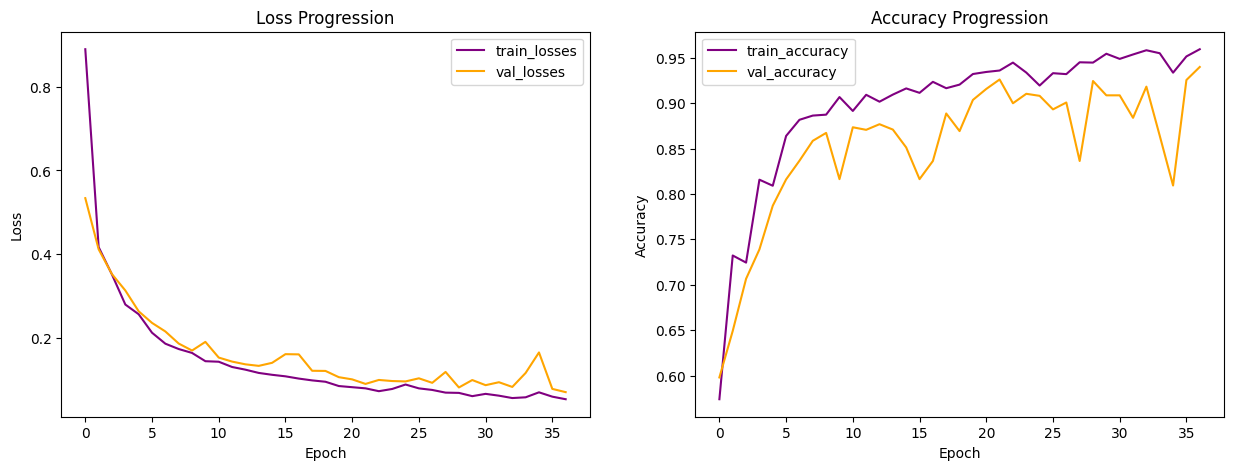

In [49]:
# visualize the loss and accuracy

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(15,5))

axes[0].plot(history.history['loss'][:best_epoch+1], color='purple', label='train_losses')
axes[0].plot(history.history['val_loss'][:best_epoch+1], color='orange', label='val_losses')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss Progression')
axes[0].legend()

axes[1].plot(history.history['weighted_accuracy'][:best_epoch+1], color='purple', label='train_accuracy')
axes[1].plot(history.history['val_weighted_accuracy'][:best_epoch+1], color='orange', label='val_accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Accuracy Progression')
axes[1].legend()
plt.show()

# evaluate the results

In [50]:
results = {}

In [51]:
import seaborn as sns
from sklearn.metrics import classification_report

`On training set`

In [52]:
# % of each class in training set
display((train_y == 0).sum()/len(train_y))
display((train_y == 1).sum()/len(train_y))
display((train_y == 2).sum()/len(train_y))

0.34382217090069284

0.33054272517321015

0.325635103926097

In [53]:
# predict using the training set
train_yhat = model.predict({
                            'Location': train_features['continent'],
                            'Features': training_features
                          })
train_yhat_result = np.argmax(train_yhat, axis=-1)

109/109 [==============================] - 2s 21ms/step


In [54]:
results['train'] = model.evaluate({
                                    'Location': train_features['continent'],
                                    'Features': training_features
                                  },
                                  train_y)[-1]

109/109 [==============================] - 4s 33ms/step - loss: 0.1815 - accuracy: 0.9411 - weighted_accuracy: 0.9411


In [55]:
print('\nTraining Classification Report\n')
print(classification_report(train_y, train_yhat_result, target_names=classes))


Training Classification Report

              precision    recall  f1-score   support

      barswa       0.94      0.95      0.95      1191
      comsan       0.90      0.97      0.93      1145
     eaywag1       1.00      0.90      0.94      1128

    accuracy                           0.94      3464
   macro avg       0.94      0.94      0.94      3464
weighted avg       0.94      0.94      0.94      3464



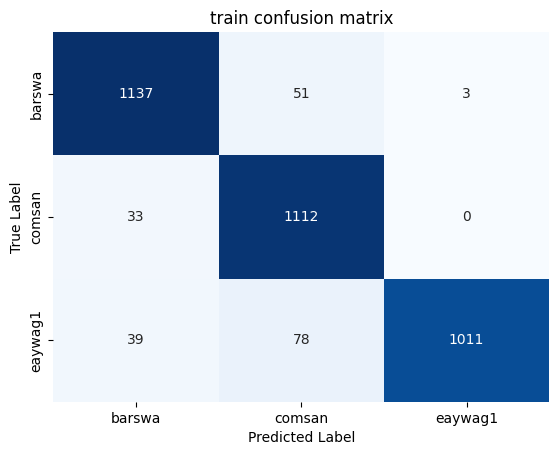

In [56]:
# calculate the confusion matrix
train_cm = tf.math.confusion_matrix(train_y, train_yhat_result)

# use a heatmap to display the confusion matrix
ax = sns.heatmap(train_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

# add axis labels
ax.set(xlabel='Predicted Label',ylabel='True Label')
plt.title('train confusion matrix')
plt.show()

`On validation set`

In [57]:
# % of each class in validation set
display((val_y == 0).sum()/len(val_y))
display((val_y == 1).sum()/len(val_y))
display((val_y == 2).sum()/len(val_y))

0.342143906020558

0.30323054331864907

0.35462555066079293

In [58]:
# predict using the validation set
val_yhat = model.predict({
                          'Location': val_features['continent'],
                          'Features': validation_features
                        })
val_yhat_result = np.argmax(val_yhat, axis=-1)

43/43 [==============================] - 1s 20ms/step


In [59]:
results['val'] = model.evaluate({
                                    'Location': val_features['continent'],
                                    'Features': validation_features
                                  },
                                  val_y)[-1]

43/43 [==============================] - 1s 20ms/step - loss: 0.2394 - accuracy: 0.9258 - weighted_accuracy: 0.9258


In [60]:
print('\nValidation Classification Report\n')
print(classification_report(val_y, val_yhat_result, target_names=classes))


Validation Classification Report

              precision    recall  f1-score   support

      barswa       0.90      0.93      0.92       466
      comsan       0.90      0.95      0.92       413
     eaywag1       0.98      0.90      0.94       483

    accuracy                           0.93      1362
   macro avg       0.93      0.93      0.93      1362
weighted avg       0.93      0.93      0.93      1362



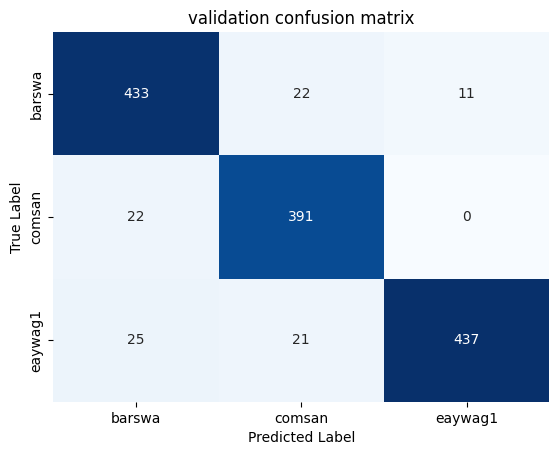

In [61]:
# calculate the confusion matrix
val_cm = tf.math.confusion_matrix(val_y, val_yhat_result)

# use a heatmap to display the confusion matrix
ax = sns.heatmap(val_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

# add axis labels
ax.set(xlabel='Predicted Label',ylabel='True Label')
plt.title('validation confusion matrix')
plt.show()

# save the model for future use

In [62]:
pd.DataFrame(list(results.items()), columns=['Train_Val', 'Overall_Accuracy']).round(2)

,Train_Val,Overall_Accuracy
0,train,0.94
1,val,0.93


In [63]:
model.save('/content/drive/MyDrive/207/207-Project/notebooks/RG/3_species/class_methods/models_h5/9a.model.h5')